# AI4ALL Project: Predicting Medium Article Engagement

## Objective and Motivation

This project aims to predict the engagement level of Medium articles using machine learning. Engagement is measured by the number of claps an article receives.

Understanding and predicting engagement can help:

- **Writers** optimize content features (title sentiment, length, timing) to boost interaction.
- **Platforms** recommend and promote highly engaging articles to improve user experience.
- **Editors** plan publishing schedules and highlight promising authors or topics.
- **Advertisers** strategically place ads for maximum visibility and revenue.

The prediction task is approached in two ways:

- **Part 1: Classification** — Identify whether an article belongs to the top 25% most engaging articles (high engagement vs. low).
- **Part 2: Regression** — Predict the actual number of claps (log-transformed to handle skewness).

## Project Plan

### Feature Engineering & Data Preparation

- Combined article title and subtitle text; extracted TF-IDF features.
- Computed sentiment scores using VADER.
- Calculated author popularity via average claps.
- Encoded categorical tags as dummy variables.
- Extracted temporal features: month, weekday, and weekend flag.
- Transformed the target variable (log transformation for regression).
- Handled missing data by dropping or imputing where appropriate.

### Models and Evaluation

- **Classification:** Random Forest with class weighting to handle imbalance.
- **Regression:** Gradient Boosting Regressor.
- Data split into train/test sets (80/20), stratified for classification.
- Metrics:
  - Classification: Precision, recall, F1-score, ROC AUC.
  - Regression: MAE, RMSE, R².
- Visual analysis with confusion matrices and predicted vs. true scatter plots.

## Data Loading and Preprocessing

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [77]:
df = pd.read_csv('medium-data-science-articles-2021.csv')
df.head()

,url,title,author,author_page,subtitle,claps,responses,reading_time,tag,date
0,https://medium.com/@dharmeshpanchmatia/data-an...,Data Analytics and AI/ML platform for eCommerce,dharmeshpanchmatia,https://medium.com/@dharmeshpanchmatia,Improve user pr,30.0,0.0,5.0,Big Data,2021-01-01
1,https://medium.com/predict/the-journey-from-an...,The journey from an Apple Silicon M1 powered l...,dimitrisv,https://medium.com/@dimitrisv,NaN,42.0,0.0,5.0,Big Data,2021-01-01
2,https://medium.com/@rajsaraogi/demystifying-kp...,Demystifying KPIs in Analytics,rajsaraogi,https://medium.com/@rajsaraogi,NaN,19.0,0.0,3.0,Big Data,2021-01-01
3,https://medium.com/@bigdataschool/%D0%B1%D0%BE...,Большая разница: чем структурированная потоков...,bigdataschool,https://medium.com/@bigdataschool,NaN,0.0,0.0,6.0,Big Data,2021-01-01
4,https://medium.com/@arnowa-44509/iot-a-new-way...,IoT: A New Way of Life,arnowa-44509,https://medium.com/@arnowa-44509,"IoT is more than just the Internet of things, ...",0.0,0.0,3.0,Big Data,2021-01-01


In [78]:
print("Data Info:")
df.info()

print("\nMissing values per column:")
print(df.isnull().sum())

print("\nSummary statistics for numerical columns:")
print(df.describe())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47660 entries, 0 to 47659
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   url           47660 non-null  object 
 1   title         47660 non-null  object 
 2   author        47660 non-null  object 
 3   author_page   47660 non-null  object 
 4   subtitle      13728 non-null  object 
 5   claps         47660 non-null  float64
 6   responses     47660 non-null  float64
 7   reading_time  47660 non-null  float64
 8   tag           47660 non-null  object 
 9   date          47660 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.6+ MB

Missing values per column:
url                 0
title               0
author              0
author_page         0
subtitle        33932
claps               0
responses           0
reading_time        0
tag                 0
date                0
dtype: int64

Summary statistics for numerical columns:
        

## Part 1: Binary Classification — High vs. Low Engagement

### Approach

Articles in the top 25% of claps are labeled as "high engagement" (1), others as "low" (0).

Features include combined text TF-IDF, sentiment, author popularity, tags, reading time, and temporal factors.

Random Forest classifier is trained with balanced class weights.

In [79]:
df['full_text'] = df['title'].fillna('') + ' ' + df['subtitle'].fillna('')

df['text_length'] = df['full_text'].apply(len)

sid = SentimentIntensityAnalyzer()
df['sentiment'] = df['full_text'].apply(lambda x: sid.polarity_scores(x)['compound'])

df['author_avg_claps'] = df.groupby('author')['claps'].transform('mean')

tags_encoded = df['tag'].str.get_dummies(sep=',')

df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.weekday
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)

clap_threshold = df['claps'].quantile(0.75)
df['engagement_label'] = df['claps'].apply(lambda x: 1 if x >= clap_threshold else 0)

vectorizer = TfidfVectorizer(max_features=200, stop_words='english')
text_tfidf = vectorizer.fit_transform(df['full_text'])
tfidf_df = pd.DataFrame(text_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df.index = df.index

feature_columns = ['reading_time', 'text_length', 'sentiment', 'author_avg_claps', 'month', 'weekday', 'is_weekend']
features = pd.concat([df[feature_columns], tags_encoded, tfidf_df], axis=1)
target = df['engagement_label']

In [80]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      7139
           1       0.84      0.84      0.84      2393

    accuracy                           0.92      9532
   macro avg       0.89      0.89      0.89      9532
weighted avg       0.92      0.92      0.92      9532

Confusion Matrix:


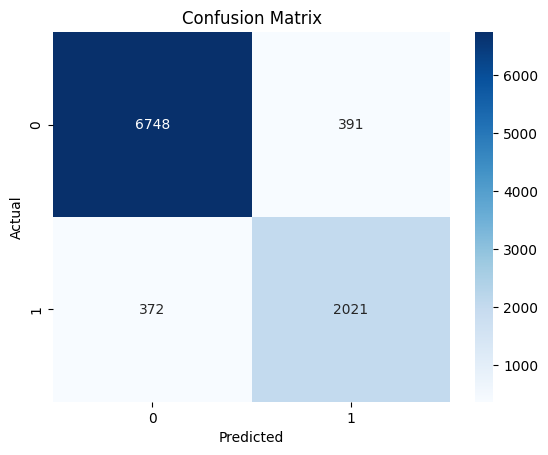

ROC AUC Score: 0.8949


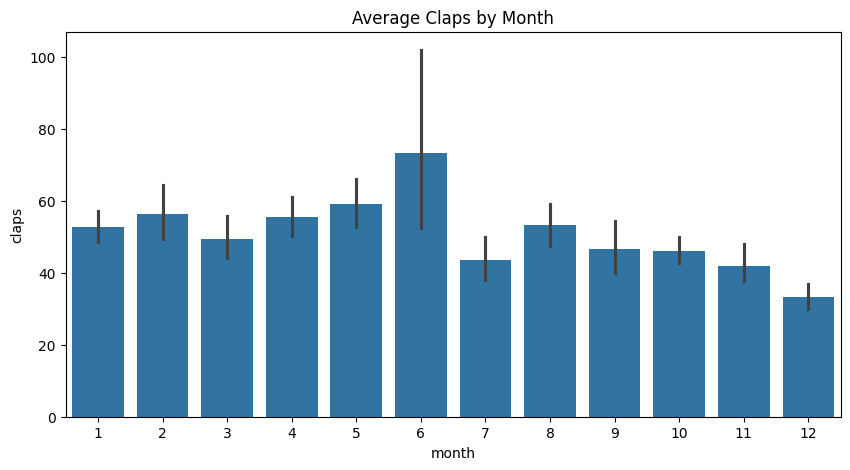

In [81]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {roc_auc:.4f}")

plt.figure(figsize=(10, 5))
sns.barplot(x='month', y='claps', data=df, estimator=np.mean)
plt.title('Average Claps by Month')
plt.show()

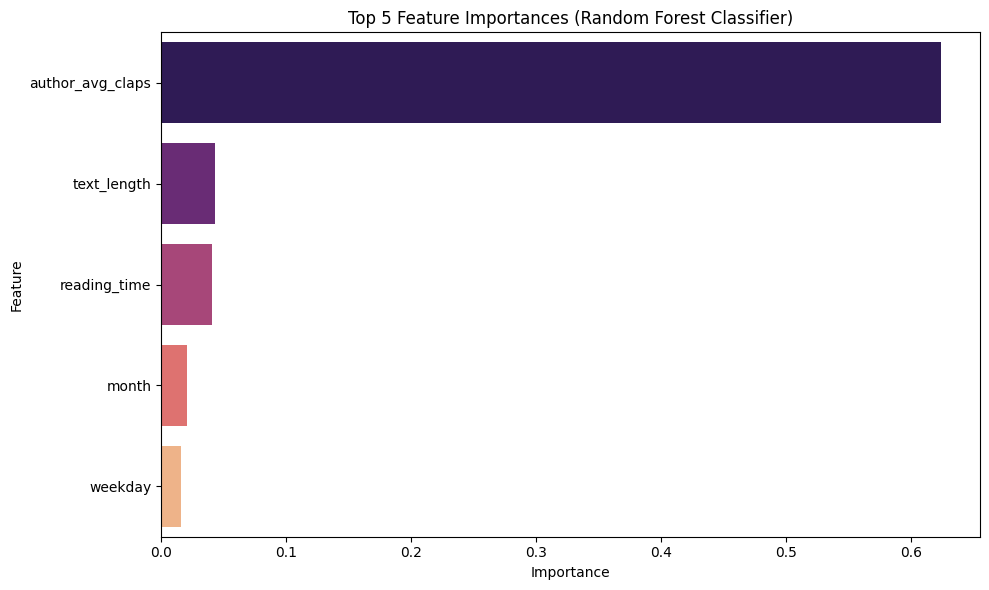

In [82]:
feature_names = features.columns
importances = clf.feature_importances_
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False).head(5)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_imp_df, palette='magma', hue='feature', legend=False)
plt.title('Top 5 Feature Importances (Random Forest Classifier)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### Analysis

- The model performs very well in identifying low-engagement articles (class 0) with high precision and recall (0.95).
- Performance on the high-engagement class (class 1) is good but slightly lower (0.84 for precision and recall), reflecting the challenge of detecting the minority/high-interest class.
- Overall accuracy of 92% and ROC AUC near 0.9 indicate strong discrimination between classes.
- The classifier can reliably flag articles likely to be highly engaging, useful for editorial or recommendation decisions.
- The most important features driving the classification were `author_avg_claps`, `text_length`, and `sentiment`. 
    - This suggests that articles written by authors with historically high engagement, more positive sentiment, and longer text tend to be more engaging.
    - Temporal features like month and weekday contributed less to the model, suggesting that engagement is more driven by content than timing.


## Part 2: Regression — Predicting Number of Claps

### Approach

The target variable is log-transformed to normalize the skewed distribution of claps.

Features include TF-IDF vectors of title and subtitle, one-hot encoded tags, numeric features like reading time, response count, and text lengths.

A Gradient Boosting Regressor is trained on this feature set.


In [83]:
df = pd.read_csv('medium-data-science-articles-2021.csv')
df = df.dropna(subset=['claps'])

df['log_claps'] = np.log1p(df['claps'])

df['has_subtitle'] = df['subtitle'].notnull().astype(int)
df['title_len'] = df['title'].fillna('').apply(lambda x: len(x.split()))
df['subtitle_len'] = df['subtitle'].fillna('').apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

df = df.dropna(subset=['reading_time', 'responses', 'tag'])

In [84]:
tfidf_title = TfidfVectorizer(max_features=100, stop_words='english')
X_title = tfidf_title.fit_transform(df['title'].fillna(''))

tfidf_subtitle = TfidfVectorizer(max_features=100, stop_words='english')
X_subtitle = tfidf_subtitle.fit_transform(df['subtitle'].fillna(''))

enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_tag = enc.fit_transform(df[['tag']])

X_num = df[['reading_time', 'responses', 'title_len', 'subtitle_len', 'has_subtitle']].values

from scipy.sparse import hstack
X = hstack([X_title, X_subtitle, X_tag, X_num])
y = df['log_claps'].values

In [85]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GradientBoostingRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

MAE: 1.25
RMSE: 1.55
R² Score: 0.32


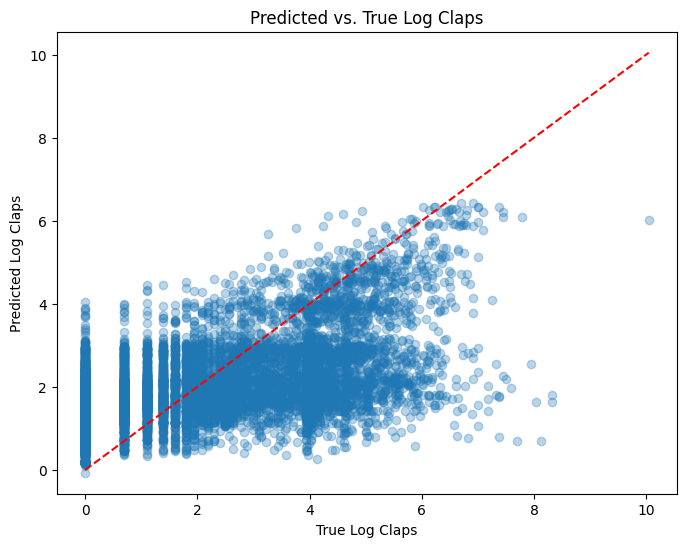

In [86]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Log Claps")
plt.ylabel("Predicted Log Claps")
plt.title("Predicted vs. True Log Claps")
plt.show()

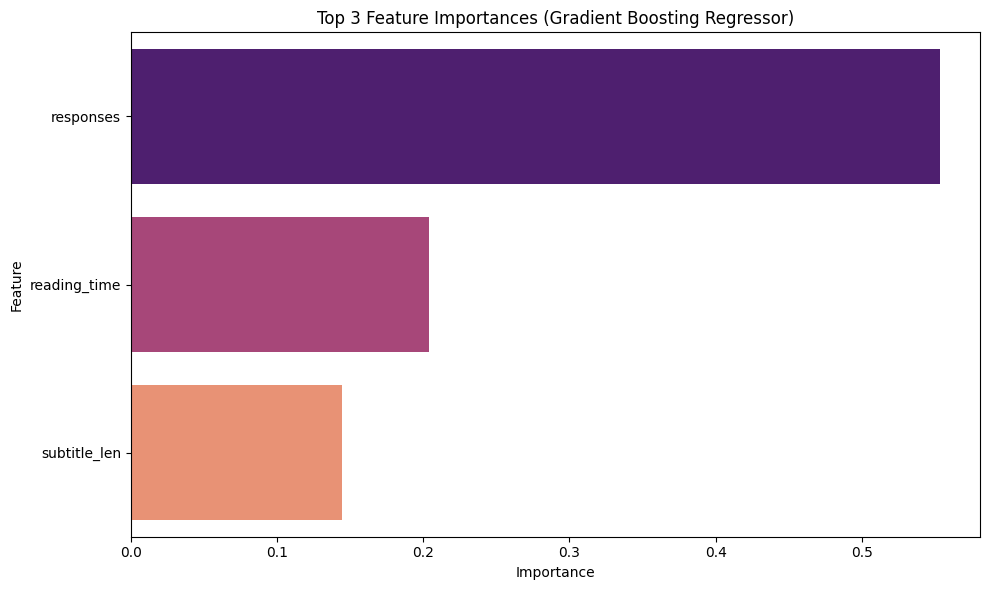

In [87]:
title_features = tfidf_title.get_feature_names_out()
subtitle_features = tfidf_subtitle.get_feature_names_out()
tag_features = enc.get_feature_names_out(['tag'])
numeric_features = ['reading_time', 'responses', 'title_len', 'subtitle_len', 'has_subtitle']

import numpy as np
all_features = np.concatenate([title_features, subtitle_features, tag_features, numeric_features])

importances = model.feature_importances_
feat_imp_df = pd.DataFrame({
    'feature': all_features,
    'importance': importances
}).sort_values(by='importance', ascending=False).head(3)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feat_imp_df, palette='magma', hue='feature', legend=False)
plt.title('Top 3 Feature Importances (Gradient Boosting Regressor)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### Analysis

- MAE of 1.25 (in log scale) indicates the model’s average absolute error on log claps, which is reasonable given engagement’s inherent variability.
- RMSE of 1.55 reflects some outliers and variance in prediction errors.
- R² of 0.32 means the model explains about 32% of the variance, suggesting room for improvement.
- The scatter plot shows the model captures the overall trend but struggles more with very high or low engagement extremes.
- Despite limitations, this regression approach provides nuanced insights into expected engagement levels beyond simple high/low classification.
- In contrast to the classifier, the regressor relied more on `responses`, `reading_time`, and `subtitle_len`, indicating these are better predictors of how many claps an article gets rather than just whether it’s highly engaging.

## Summary and Next Steps

### Summary of Results

**Part 1: Classification (High vs. Low Engagement)**  
- The Random Forest classifier achieved an overall accuracy of 92%, with strong precision and recall on the majority class (low engagement).  
- Performance on the high engagement class (top 25%) was solid, with precision and recall both around 0.84, demonstrating the model's ability to identify highly engaging articles reasonably well.  
- The ROC AUC score of 0.89 indicates the model discriminates well between high and low engagement articles.  
- This classification approach is valuable for quick filtering or prioritization of content for editors, recommendation systems, or ad placement.

**Part 2: Regression (Predicting Number of Claps)**  
- The Gradient Boosting Regressor predicts log-transformed clap counts with a Mean Absolute Error (MAE) of 1.25 and Root Mean Squared Error (RMSE) of 1.55, reflecting reasonable accuracy given the noisy nature of engagement data.  
- An R² score of 0.32 indicates the model explains about one-third of the variance in article claps, leaving substantial scope for improvement.  
- The scatter plot of predicted vs. true log claps shows the model captures the general trend but tends to underperform at the extremes of engagement (very low or very high claps).  
- Regression provides more granular predictions of engagement levels, useful for detailed content performance analysis and personalized recommendations.

**Additional Insights: Average Claps by Month**  
- Analysis of average claps per month reveals seasonal trends in engagement, with some months consistently seeing higher average claps.  
- These temporal patterns suggest that publishing timing can be optimized to maximize reader interaction.

### Next Steps and Recommendations

- **Feature Engineering:** Incorporate additional features such as article topic modeling, author social media metrics, or more granular temporal features (e.g., time of day, holidays).  
- **Model Improvements:** Experiment with advanced models (e.g., XGBoost, neural networks) and ensemble approaches. Conduct hyperparameter tuning and cross-validation to boost performance.  
- **Handling Imbalance:** For classification, explore alternative methods to address class imbalance such as SMOTE or focal loss.  
- **Interpretability:** Use SHAP values or feature importance analysis to better understand key drivers of engagement, enabling actionable recommendations for content creators.  

By combining classification and regression perspectives, this project lays the foundation for a comprehensive engagement prediction system that can guide writers, editors, platforms, and advertisers toward data-driven decisions.